In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def loss_function(rec_x, x, mu, log):
    BCE = nn.BCELoss(reduction='sum')
    rec_loss = BCE(rec_x, x)
    KL = -0.5 * torch.sum(1+log-torch.exp(log)-mu**2)
    
#     print(rec_loss, kl_divergence)
    return (rec_loss + KL)/rec_x.size(0)

In [32]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.conv1 = nn.Conv2d(1, 10,kernel_size=(5,5))
        self.conv2 = nn.Conv2d(10,20, kernel_size=(5,5))
        self.pooling = nn.MaxPool2d(2)
        self.fc11 = nn.Linear(320,2)
        self.fc12 = nn.Linear(320,2)
        self.fc2 = nn.Linear(2,350)
        self.fc3 = nn.Linear(350,784)
#         self.fc1 = nn.Linear(784,350)
#         self.fc_mean = nn.Linear(350,2)
#         self.fc_log = nn.Linear(350,2)
#         self.fc2 = nn.Linear(2,350)
#         self.fc3 = nn.Linear(350,784)
        
    def encode(self, x):
        batch_size = x.size(0)
#         print(x.shape)
#         x = self.conv1(x)
#         print(x.shape)
#         x = self.pooling(x)
#         print(x.shape)
#         x = F.relu(x)
#         print(x.shape)
#         x = self.conv2(x)
#         print(x.shape)
#         x = self.pooling(x)
#         print(x.shape)
#         x = F.relu(x)
#         x = x.view(batch_size,-1)
        x = self.conv1(x)
        x = self.pooling(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = F.relu(x)
        x = x.view(batch_size,-1)
        return self.fc11(x), self.fc12(x)
    
    def reparametrization(self, mu, log):
        std = 0.5 * torch.exp(log)
        z = torch.randn(std.size()) * std +mu
        return z
    
    def decode(self, z):
        x = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(x))
    
    def forward(self,x):
#         print(x.shape)
        mu, log = self.encode(x)
        z = self.reparametrization(mu, log)
        return self.decode(z), mu, log

In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [34]:
training_set = torchvision.datasets.MNIST(root='../../dataset/mnist/', 
                                         train=True,
                                         download=True,
                                         transform=transform)
training_loader = torch.utils.data.DataLoader(training_set,batch_size=100, shuffle=True)
test_set = torchvision.datasets.MNIST(root='../../dataset/mnist/',
                                      train=False,
                                      download=True,
                                      transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

In [35]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters())

In [36]:
def train(epoch):
    vae.train()
    loss = 0
    loss_list = []
    for batch_idx,(inputs, targets) in enumerate(training_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        
        gen_imgs, mu, log = vae(inputs.view(-1,1,28,28))
        inputs = inputs.view(-1,784)
        l = loss_function(gen_imgs, inputs, mu, log)
        
        l.backward()
        optimizer.step()
        
        loss += l.item()
        if batch_idx % 99 == 0:
            loss_ave = loss/(batch_idx+1)
            loss_list.append(loss_ave)
            print('Epoch %d, loss:%.5f' % (epoch, loss_ave))
    return loss_list

In [37]:
loss_list2 = []
for i in range(50):
    loss_list2 += train(i)
    with torch.no_grad():
        z = torch.randn(64, 2)
        sample = vae.decode(z)
        gen_images = sample.view(-1,1,28,28)
        save_image(gen_images, './MNIST_GAN/vae_images'+str(i)+'.png')

Epoch 0, loss:549.27966
Epoch 0, loss:246.53525
Epoch 0, loss:224.68210
Epoch 0, loss:211.28331
Epoch 0, loss:202.70945
Epoch 0, loss:197.20388
Epoch 0, loss:192.92792
Epoch 1, loss:164.44087
Epoch 1, loss:170.55575
Epoch 1, loss:169.87973
Epoch 1, loss:169.34241
Epoch 1, loss:168.70693
Epoch 1, loss:168.15366
Epoch 1, loss:167.68710
Epoch 2, loss:172.88017
Epoch 2, loss:164.30096
Epoch 2, loss:164.10952
Epoch 2, loss:163.90636
Epoch 2, loss:163.55882
Epoch 2, loss:163.40707
Epoch 2, loss:163.21505
Epoch 3, loss:155.24101
Epoch 3, loss:161.52544
Epoch 3, loss:161.14617
Epoch 3, loss:160.83172
Epoch 3, loss:160.53555
Epoch 3, loss:160.33132
Epoch 3, loss:160.18317
Epoch 4, loss:150.85928
Epoch 4, loss:158.84400
Epoch 4, loss:158.35918
Epoch 4, loss:158.27883
Epoch 4, loss:158.33416
Epoch 4, loss:158.31623
Epoch 4, loss:158.18038
Epoch 5, loss:152.17174
Epoch 5, loss:157.16822
Epoch 5, loss:156.82162
Epoch 5, loss:156.57649
Epoch 5, loss:156.73641
Epoch 5, loss:156.78446
Epoch 5, loss:15

Epoch 47, loss:147.42900
Epoch 47, loss:147.20757
Epoch 47, loss:147.48834
Epoch 47, loss:147.43946
Epoch 47, loss:147.45471
Epoch 48, loss:152.59753
Epoch 48, loss:146.92653
Epoch 48, loss:146.95153
Epoch 48, loss:147.22370
Epoch 48, loss:147.17938
Epoch 48, loss:147.27927
Epoch 48, loss:147.37331
Epoch 49, loss:148.90254
Epoch 49, loss:147.61844
Epoch 49, loss:147.29629
Epoch 49, loss:147.35733
Epoch 49, loss:147.30747
Epoch 49, loss:147.19355
Epoch 49, loss:147.31276


torch.Size([64, 1, 28, 28])


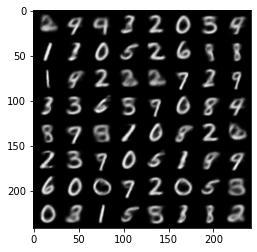

In [23]:
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decode(z)
    gen_images = sample.view(-1,1,28,28)
    print(gen_images.shape)
    save_image(gen_images, './MNIST_GAN/vae_images.png')
    img = plt.imread('./MNIST_GAN/vae_images.png')
    plt.imshow(img)

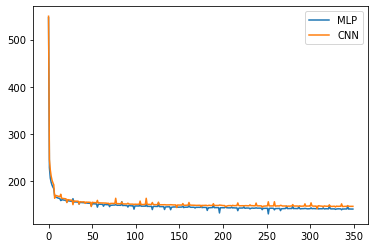

In [42]:
plt.figure()
plt.plot(loss_list1)
plt.plot(loss_list2)
plt.legend(['MLP','CNN'])
plt.savefig('VAE.png')

In [25]:
l1 = loss_list